In [1]:
import sys
sys.path.insert(0, '/Users/aymane/School/Senior Design/pothole-localization/src/data')
sys.path.insert(1, '/Users/aymane/School/Senior Design/pothole-localization/src/helper')

#TODO add all modules to path using a function
import torch
import torch.utils.data 
import numpy as np
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from dataset import SegDataset
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

# feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512", size=(400, 400), do_normalize=False)
dataset = SegDataset(path='/Users/aymane/School/Senior Design/pothole-localization/data/segmentation/raw')

train, test, valid = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])

train_data  = DataLoader(dataset=train, batch_size=1, shuffle=True, num_workers=8)
test_data   = DataLoader(dataset=test, batch_size=1, shuffle=False, num_workers=8)
valid_data  = DataLoader(dataset=valid, batch_size=1, shuffle=False, num_workers=8)

/Users/aymane/School/Senior Design/pothole-localization/src/data/dataset.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor      = torch.tensor(transform(img)).detach().clone().squeeze_()
/Users/aymane/School/Senior Design/pothole-localization/src/data/dataset.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_tensor    = torch.tensor(transform(label)).detach().clone().squeeze_()


ValueError: only one element tensors can be converted to Python scalars

: 

In [10]:
len(train_data)

480

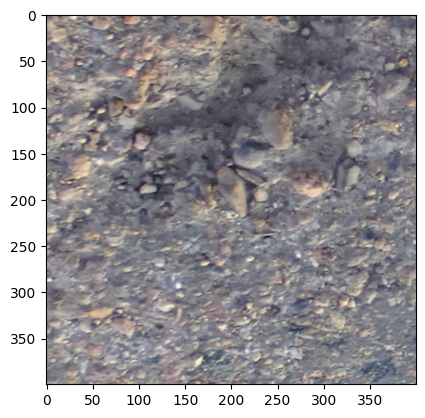

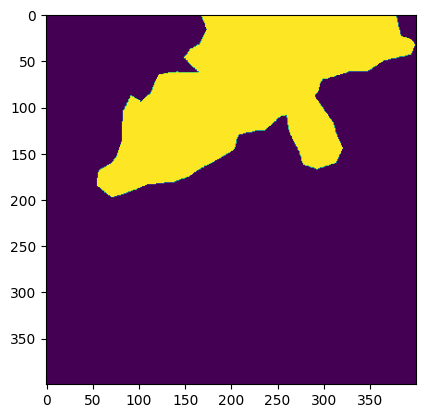

In [9]:
# import required libraries
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from display_image import display_image as di


# define a torch tensor
i = 120
tensor1 = train[i][0]
tensor2 = train[i][1]

di(tensor1)
di(tensor2)

In [3]:
from segtune import SegformerFinetuner 

segformer_finetuner = SegformerFinetuner(
    train_dataloader=train_data, 
    val_dataloader=valid_data, 
    test_dataloader=test_data, 
    metrics_interval=10,
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/aymane/School/Senior Design/pothole-localization/src/helper/segtune.py:34: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  self.train_mean_iou = load_metric("mean_iou")


In [4]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    min_delta=0.00, 
    patience=3, 
    verbose=False, 
    mode="min",
)

checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="val_loss")

trainer = pl.Trainer(
    precision=16,
    gpus=0, 
    callbacks=[early_stop_callback, checkpoint_callback],
    max_epochs=500,
    val_check_interval=len(train),
)

trainer.fit(segformer_finetuner)

/Users/aymane/School/Senior Design/pothole-localization/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
/Users/aymane/School/Senior Design/pothole-localization/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:704: UserWarning: You passed `Trainer(accelerator='cpu', precision=16)` but native AMP is not supported on CPU. Using `precision='bf16'` instead.
  rank_zero_warn(
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/aymane/School/Senior Design/pothole-localization/notebooks/lightning_logs

  | Name  | Type                     

Sanity Checking: 0it [00:00, ?it/s]

RuntimeError: expected scalar type BFloat16 but found Float